# Digits extraction

This notebook presents a usage example of how the digits extraction capability can be developed on the segmented image.

In [1]:
import segmentation as seg
from PIL import Image
import matplotlib.pyplot as plt
import torch
from math import ceil
import numpy as np

image = "../img/input/img-202114-215659.png"

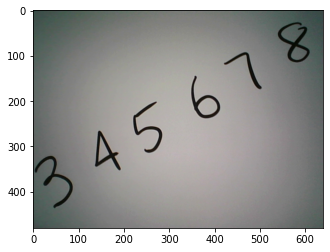

In [2]:
original = Image.open(image)
plt.imshow(original)

The graph-based segmentation algorithm is applied to the input image by using appropriate tuning parameters `k` and `min_size`, and some preprocessing operations (gaussian blur) too.

In [3]:
segmented = seg.GraphBasedSegmentation(image)
segmented.segment(
                  k=4500
                , min_size=100
                , preprocessing=True
                , gaussian_blur=2.3)

Once the image has been segmented it can be generated (by mean of the `generate_image()` method) and then the boxes are drawn around each digit (if they are correctly drawn, this proves that the digit extraction procedure could procede in the proper way).

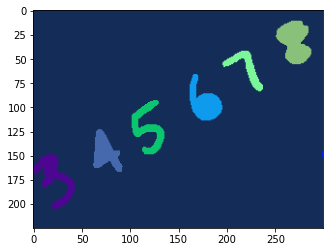

In [4]:
segmented.generate_image()
plt.imshow(segmented.segmented_img)

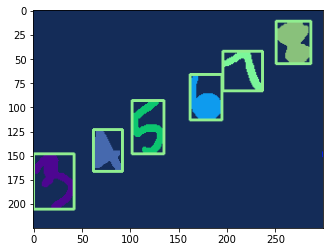

In [5]:
segmented.draw_boxes()
plt.imshow(segmented.boxed_img)

A possible future development could be the one of drawing the boxes accordingly to the degree orientation of the digits. In this case, since the network can be trained using the data augmentation technique - which involves applying random rotations (within -15° and +15°) of the training samples -, we can exploit this harder training in order to let the network guess the number even if it is presented a bit rotated.

Here, the implementation of the `extract_digits()` function is reported (it has been also translated into a method for the `GraphBasedSegmentation()` class).

The function works as follows:
- it takes the regions in which the digits fall
- for each region, it uses its extremes to slice the original image array
- once the slice is ready, it can be preprocessed in order to obtain an image which is as close as possibile to the ones that the network has seen during the training phase
    - threshold to convert gray background into white
    - resize to 28x28 pixels
    - negative to make the background black and the digit white (as in our MNIST)
- the image is returned as `torch.tensor` having dimensions `[#digits, 1, 28, 28]` as requested by the CNN

In [6]:
def extract_digits(segmented_) -> torch.tensor:
    """ 
    Extract the single digits from the segmented image.
    """
    
    digits = []
    for _, digit_info in segmented_.digits_regions.items():
        
        # find digit extremes
        # ---------------------------------
        a = digit_info['extremes'][0]
        b = digit_info['extremes'][1] + 1
        c = digit_info['extremes'][2]
        d = digit_info['extremes'][3] + 1
        # ---------------------------------

        # slice original image array around digit
        # ---------------------------------
        digit = segmented_.preprocessed_arr[a:b,c:d].copy()
        # ---------------------------------

        # apply threshold to move background to white
        # ---------------------------------
        threshold = lambda el, t: np.uint8(el) if el < t else np.uint8(255)
        threshold_func = np.vectorize(threshold)
        digit = threshold_func(digit, 50)
        # ---------------------------------

        # resize image
        # ---------------------------------
        height, width = digit.shape
        if height > width:
            diff = height - width
            left_cols_num = ceil((diff) / 2)
            right_cols_num = diff - left_cols_num
            digit = np.pad(digit, ((0,0),(right_cols_num, left_cols_num)), 'maximum')
        else:
            diff = width - height
            top_rows_num = ceil((diff) / 2)
            bottom_rows_num = diff - top_rows_num
            digit = np.pad(digit, ((bottom_rows_num, top_rows_num),(0,0)), 'maximum')
        
        digit = Image.fromarray(digit)  # convert to PIL
        digit = digit.resize((28,28))   # resize to 28x28 as MNIST input
        digit = np.array(digit)         # convert to np.array
        # ---------------------------------

        digits.append(digit)

    # convert to torch tensor and add an empty dimension (needed in net.forward)
    digits = torch.FloatTensor(np.array(digits))
    return torch.unsqueeze(digits, 1)
        
    

Having defined the function we can use it to extract the digits (here the class method is used).

In [7]:
segmented.extract_digits()
segmented.digits.shape

torch.Size([6, 1, 28, 28])

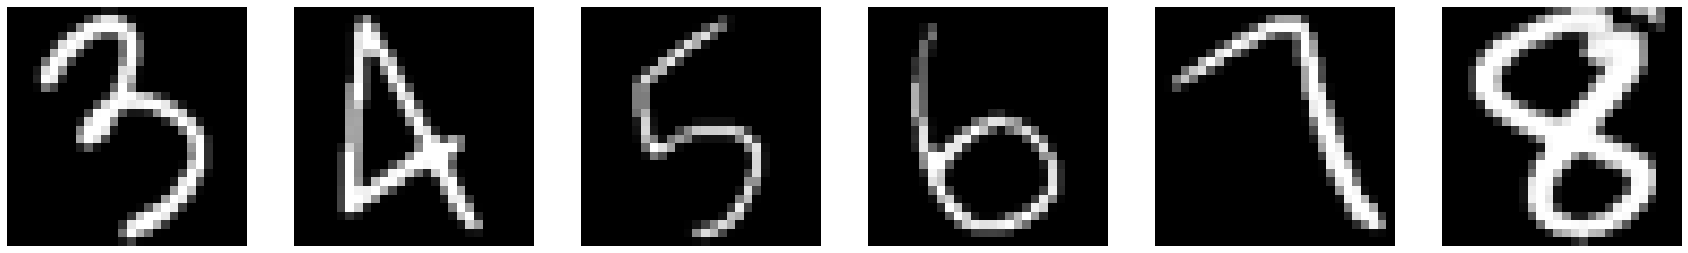

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,15))
for i in range(len(segmented.digits)):
    image = segmented.digits[i][0]
    sp = fig.add_subplot(3, len(segmented.digits), i+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')